**линейная регрессия, аналитическое решение**

Евгений Борисов  <esborisov@sevsu.ru>

# генерируем набор данных

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt

In [2]:
np.set_printoptions(precision=2)

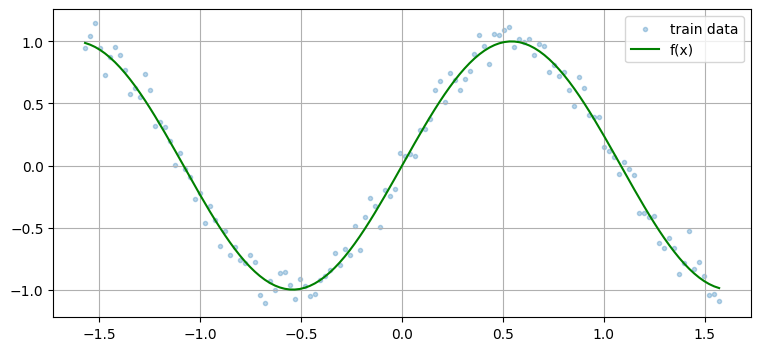

In [48]:
def f(x):
    return np.sin(x*2.9)

def generate(n_samples=128, noise=.1):
    x = np.linspace(-np.pi/2.,+np.pi/2.,n_samples)
    return x.reshape(-1,1), (f(x)+rng.normal(0., noise, n_samples)).reshape(-1,1)

X_train,y_train = generate()

# рисуем результат
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(x=X_train,y=y_train,alpha=.3,marker='.',label='train data') # точки учебного набора
ax.plot(X_train,f(X_train),c='g',label='f(x)')
ax.grid()
ax.legend()

## модель

$$a(x,w) = \sum\limits_{i=1} x_i \cdot w_i + w_0$$

In [50]:
class LinearRegression:
    
    def __init__( self, weight=np.array([]) ):
        self._weight = weight
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return x.dot(self._weight)
    
    def predict(self,x): 
        return self.score(x)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
            
    def score_partial(self,x): # частные производные модели по её параметрам
        return x

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

частные производные функции потери по параметрам модели (градиент)

$$ \frac{\partial L }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

In [51]:
class MSQELoss:

    @staticmethod
    def score(target,predicted): 
        d = predicted - target
        return d.T.dot(d).flatten()[0]/len(d)
    
    @staticmethod
    def partial( target, predicted, model_partial, ): # градиент функции потери,
        g = model_partial.T.dot( predicted - target ) # градиент msqe
        #g /= np.abs(g).max() # нормируем градиент
        return g

In [52]:
from tqdm.auto import tqdm

In [53]:
class RegressionTrainSGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss            
    
    def fit( self, X, target, lr=1e-4, n_epoch=512, loss_min=1e-3, batch_size=10, ): 
        # lr - скорость обучения
        # n_epoch - максимальное число циклов обучения
        # loss_min - порог минимально допустимой погрешности модели

        # n_samples = len(target) # количество примеров
        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight = rng.normal(size=(n_param,1),scale=.001)

        # начальное значение ф-ции потери
        loss_history = [ self._loss.score(target,self._model.score(X)) ]

        for i in tqdm(range(n_epoch)): # цикл обучения
            self._fit_epoch(X,target,lr,batch_size) # корректируем веса модели
            loss_history.append(  self._loss.score(target,self._model.score(X)) ) # считаем значение ф-ции потери

            if loss_history[-1] < loss_min: # проверяем достижение минимального порога погрешности модели
                print('step %i/%i: loss threshold %.03f reached\n'%(
                    i+1,n_epoch,loss_history[-1]
                    ))
                break   
        return loss_history, self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target,lr,batch_size):
        for x,y in self._get_batch(X,target,batch_size):
            self._fit_batch(x,y,lr)
        return self
    
    @staticmethod
    def _get_batch(X,target,batch_size):
        ii = rng.permutation(range(len(X_train)))
        for n in range(0,len(ii)-batch_size,batch_size):
            yield X[n:n+batch_size,:],target[n:n+batch_size,:]
        
    def _fit_batch(self,X,target,lr):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X) ) 
        self._weight_adjust(g,lr) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g,lr):
        self._model.weight = self._model.weight - lr*g # корректируем параметры
        return self

In [84]:
from sklearn.preprocessing import PolynomialFeatures

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures( 
        degree=5, 
        interaction_only=False, 
        include_bias=True,
    ).fit( X_train )

  0%|          | 0/512 [00:00<?, ?it/s]

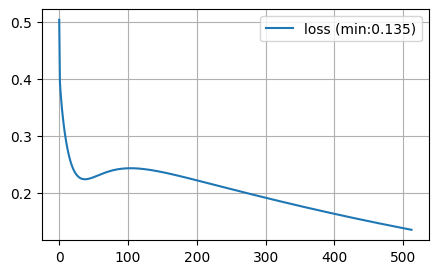

In [91]:
loss_history,model = RegressionTrainSGD(
        model=LinearRegression(),
        loss=MSQELoss(),
    ).fit(
        poly.transform(X_train),  y_train,
        lr=1e-3, n_epoch=512, loss_min=9e-2
    )

# история изменения значений погрешности модели
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(loss_history,label=f'loss (min:{min(loss_history):.3f})' )
ax.grid()
ax.legend()

## тестируем

In [92]:
X_test,y_test = generate()

predicted = scaler_y.inverse_transform( model.predict(poly.transform(scaler_x.transform(X_test))) )
# predicted = scaler_y.inverse_transform( model.predict(poly.transform(scaler_x.transform(X_train))) )

0.13130307314140813

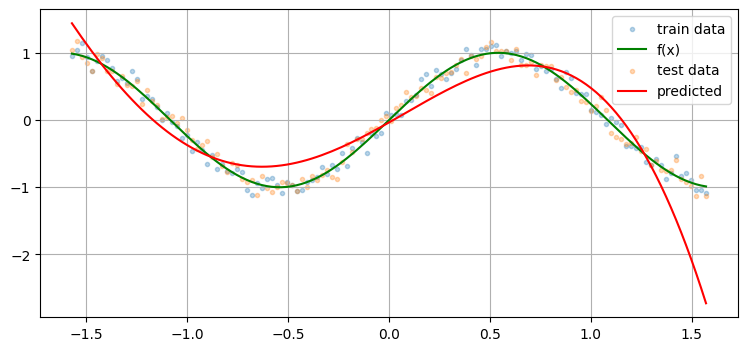

In [93]:
from sklearn.metrics import mean_squared_error

display( mean_squared_error( y_true=y_test, y_pred = predicted ) )

# рисуем результат
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(x=X_train,y=y_train,alpha=.3,marker='.',label='train data') # точки учебного набора
ax.plot(X_train,f(X_train),c='g',label='f(x)')
ax.scatter(x=X_test,y=y_test,alpha=.3,marker='.',label='test data') # точки учебного набора
ax.plot(X_test,predicted,c='r',label='predicted')
ax.grid()
ax.legend()